# Hyper Tuning  notebook

## • The aim of this notebook is to deploy our data in web app online so that it will be able to apply soft code and make our model applicable and more dynamic

## • Our online link for this local host application "https://webappfinalproject-samcc5ldyserhfhxqoarel.streamlit.app "

## • The flow will be as following :

## • Creat streamlit web app

## • Create login form to autheniticate the super admin only for secuirty purpose

## • Move to page with upload button to upload csv file 

## • The last page for dashboard which containes predictions and alot of visuals with side bar has filters

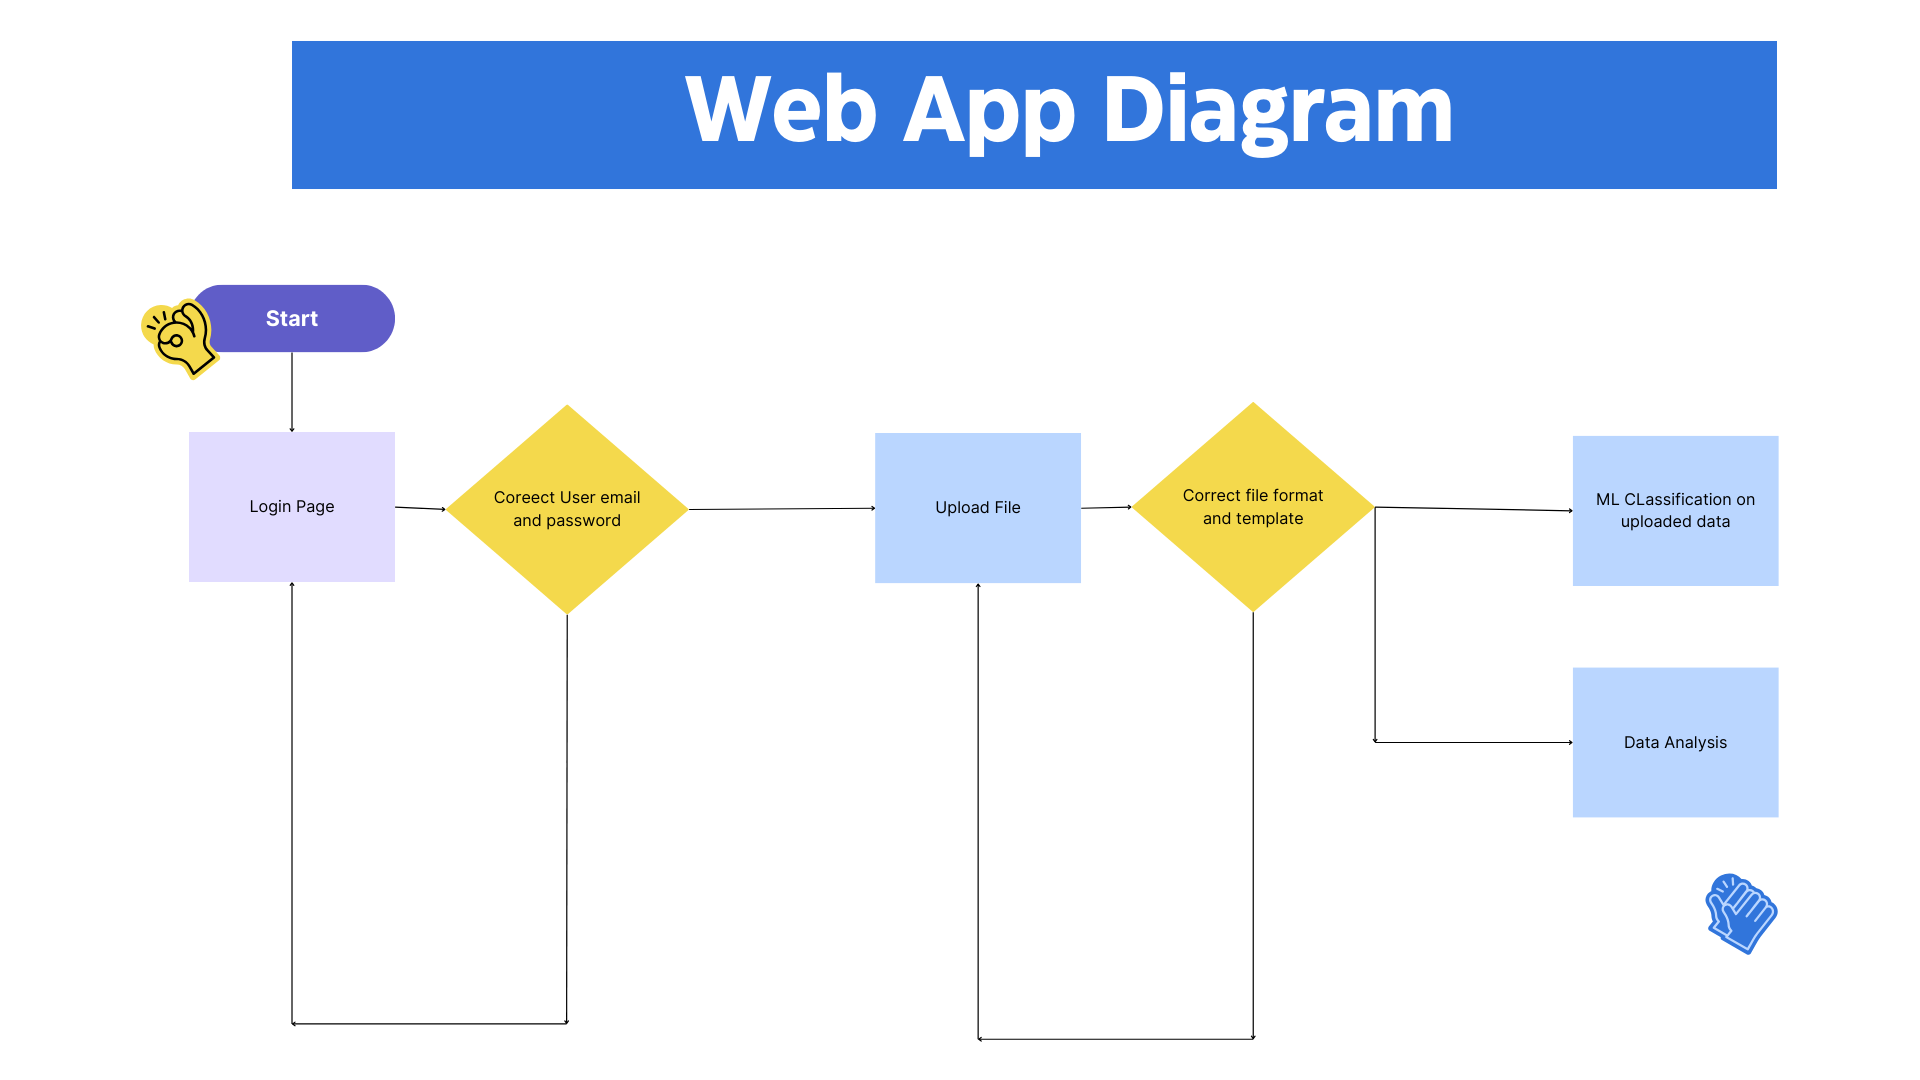

In [98]:
%%writefile app.py
#important libraries for our app
import streamlit as st
#import libraries that is going to be used in our project 
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import pickle
#function to authenticate user
def authenticate_user(email, password):
    #super admin credentials
    #user email is omar@epsilonai.com and password is 011235813
    return email == "omar@epsilonai.com" and password == "011235813"

#function to apply manual pipeline to the coming data (cleaning,feature engineering and encoding) then predict and return the target column of our uploaded data
def pip_predict(x): 
    #rename columns
    #check columns
    #rename columns regrading to the standards
    x.columns=x.columns.str.lower().str.strip().str.replace(" ","_")
    #fill missing values
    #the first part of na columns
    lst_na_values=['monthly_inhand_salary','num_of_delayed_payment','num_credit_inquiries','credit_history_age','amount_invested_monthly','monthly_balance']
    #loop in lst_na_values and replace every na with 0 value
    for i in lst_na_values :
        x[i]=x[i].fillna(0)
    #the second part of na columns
    x['name']=x['name'].fillna(x['name'].mode()[0])
    x['type_of_loan']=x['type_of_loan'].fillna('unknown')  
    #the first part of columns
    #feature engineering
    #year column
    def convert_years(y):
        if y == 0 :
            return y
        else :
            return int(y.split('Years')[0])  
    x['credit_history_year']=x['credit_history_age'].apply(convert_years)
    #month column
    def convert_months(y):
        if y == 0 :
            return y
        else :
            return y[-9:-7]
    x['credit_history_month']=x['credit_history_age'].apply(convert_months)
    x['credit_history_month']=x['credit_history_month'].replace('',0)
    x['credit_history_month']=x['credit_history_month'].astype(int)
    #drop credit_history_age column because it is redunant
    x.drop('credit_history_age',axis=1,inplace=True)
    #here we found age columns consists of 4 digits some times which is not logical so we can take the first two digits 
    def age(y):
        return y[:2]
    x['age']=x['age'].apply(age)
    #we also has the '_' symbol to be replaced with space better
    x['age']=x['age'].replace('_',' ')
    #convert age column to positive int
    def edit_age(y):
        return abs(int(y))
    x['age']=x['age'].apply(edit_age)
    lst_num=['annual_income', 'num_of_loan', 'num_of_delayed_payment','outstanding_debt','amount_invested_monthly','monthly_balance']
    #we have found that the rest of numerical columns  has the '_' symbol to be replaced with space better (convert it to string first) then reconvert it to numerical value (int)
    def edit_rest(y):
        y=str(y)
        y=y.replace('_',' ')
        return int(y.split('.')[0])
    for i in lst_num:
        x[i]=x[i].apply(edit_rest) 
    #convert the monthly_balanced column to numerical variable
    x['monthly_balance']=x['monthly_balance'].astype(float)
    x['monthly_balance']=x['monthly_balance'].astype(int)
    #create list of object feature at the first part of columns
    lst_obj=['credit_mix', 'payment_of_min_amount', 'payment_behaviour']
    x['credit_mix']=x['credit_mix'].replace(0,'unknown')
    #also convert these object features into string again
    for i in lst_obj:
        x[i]=x[i].astype(object)
    #encoding
    #collect the rest of categorical features at the first part
    lst_obj=['credit_mix', 'payment_of_min_amount', 'payment_behaviour']
    #we have notice there are strange special variables needed to be replace with most frequent id of column
    #for payment_behaviour there is ('!@9#%8')
    x['payment_behaviour']=x['payment_behaviour'].replace('!@9#%8',x['payment_behaviour'].mode()[0])
    #for payment_behaviour there is ('VM')
    x['payment_of_min_amount']=x['payment_of_min_amount'].replace('NM',x['payment_of_min_amount'].mode()[0])
    #label encoding
    #craate the desirable dictionaries to map them with columns later
    credit_mix_dic={

                            '_':0,
                            'Bad':1,
                            'Standard':2,
                            'Good':3   
    }

    payment_behaviour_dic={

                            'Low_spent_Small_value_payments':0,
                            'Low_spent_Medium_value_payments':1,
                            'High_spent_Small_value_payments':2,
                            'Low_spent_Large_value_payments':3,
                            'High_spent_Medium_value_payments':4,
                            'High_spent_Large_value_payments':5
    }


    #map these dictionaries
    #collect them in a list
    lst_dic=[credit_mix_dic,payment_behaviour_dic]
    lst_label=lst_obj.copy()
    lst_label.remove('payment_of_min_amount')
    for i in range(len(lst_label)):
        x[lst_label[i]]=x[lst_label[i]].map(lst_dic[i])
    #one hot encoding
    dummies=pd.get_dummies(x['payment_of_min_amount'])
    x=pd.concat([x,dummies],axis=1)
    #drop the orginal column
    x.drop('payment_of_min_amount',axis=1,inplace=True)
    #the second part of columns
    #feature engineering
    #month column
    #convert string names of months to numerical value
    #convert it into data data type then to int nuemrical value
    x['month']=pd.to_datetime(x['month'],format="%B").dt.month.astype(int)
    #ssn column
    #we have noticed that every ssn associated with customer id and there is one special case for ssn to be replace with 000-00-0000
    #create dictiopnary to map customer id to ssn
    #dropna in case there are na values
    ssn_mapping = x.dropna(subset=['ssn']).set_index('customer_id')['ssn'].to_dict()
    #apply map using get function to associate key with value of dictionary
    x['ssn'] = x.apply(lambda row: ssn_mapping.get(row['customer_id'], row['ssn']), axis=1)
    #convert ssn to numerical value
    def edit_ssn(y):
        #special case
        if y == '#F%$D@*&8':
            y ='000-00-0000'
            return int(''.join(y.split('-')))
        else :
            #convert string to integer value
            return int(''.join(y.split('-')))
    x['ssn']=x['ssn'].apply(edit_ssn)
    #occupation column
    #create dictiopnary to map customer id to occupation
    #dropna in case there are na values
    occupation_mapping = x.dropna(subset=['occupation']).set_index('customer_id')['occupation'].to_dict()
    #apply map using get function to associate key with value of dictionary
    x['occupation'] = x.apply(lambda row: occupation_mapping.get(row['customer_id'], row['occupation']), axis=1)
    #encoding the second part of the columns
    lst_obj=['id','customer_id','name','occupation','type_of_loan','changed_credit_limit']
    #so our decision will be as follwing
    #for name and occupation columns we will use leave one out encoder depends on credit score from preprocessed df
    #for the rest of columns we will use the mean of credit score for each column
    #we will use one column only from preprocessed data frame which is credit score
    #apply the first type of encoding
    #import the desired library
    import category_encoders as ce
    lst_leave=['name','occupation']
    for i in lst_leave :
        x[i]=ce.LeaveOneOutEncoder().fit_transform(x[i],x['credit_mix'])
    #apply the second type of encoding
    #import the desired library
    lst_rest=['id','customer_id','type_of_loan','changed_credit_limit']
    for i in lst_rest :
        mean_feature = x.groupby([i])['credit_mix'].mean()
        x[i] = x[i].map(mean_feature)
    #finalize data types to be the same like saved trained model
    lst_int64=['month', 'ssn', 'num_bank_accounts', 'num_credit_card', 'age','interest_rate', 'num_of_loan', 'delay_from_due_date','num_of_delayed_payment', 'credit_mix', 'outstanding_debt','amount_invested_monthly', 'payment_behaviour', 'monthly_balance','credit_history_year', 'credit_history_month', 'No', 'Yes']
    for i in lst_int64 :
        x[i]=x[i].astype('int64')
    lst_float64=['id', 'customer_id', 'name', 'occupation', 'type_of_loan','changed_credit_limit', 'monthly_inhand_salary', 'annual_income','num_credit_inquiries', 'credit_utilization_ratio','total_emi_per_month']   
    for i in lst_float64 :
        x[i]=x[i].astype('float64')    
    #open our saved trained model ---> the best model and performance we can get
    #apply prediction
    #load the model
    #load the pickled model
    pickled_model = pickle.load(open('../models/train_model.pkl', 'rb'))
    #Standarization
    #create standard scaler object
    scaler = StandardScaler()
    x_df = scaler.fit_transform(x)    
    # Continue with your code using the loaded model
    z = pickled_model.predict(x_df)
    #create data frame with the predictor column
    y_f=pd.DataFrame((z),columns=['credit_score'])
    y_f['credit_score']=y_f['credit_score']
    #apply decoding so that string appear at the end instead of numbers
    def decode(x):
        x=str(x)
        if x == '0' :
            return 'Poor'
        elif x == '1' :
            return 'Standard'
        elif x =='2' :
            return 'Good'
    y_f['credit_score']=y_f['credit_score'].apply(decode)
    return y_f


#web app
def main():
#meta data for our web app (layout , fav icon , page title)
    st.set_page_config(
        layout="wide",
        page_icon='💰',
        page_title='Credit Score Prediction App',    
    )    
    

#login phase
    #check if the user already logged in
    is_logged_in = st.session_state.get('is_logged_in', False)
    #check cases for login
    if not is_logged_in:
        #change title color to white to fit black color of background image
        st.markdown('<h1 style="text-align: center; color : #000;font-size:24px,font-family:pt-serif">Sign in</h1>', unsafe_allow_html=True)
        #login form
        email = st.text_input("Email")
        password = st.text_input("Password", type="password")
        login_button = st.button("Login")
    
        if login_button:
            #after successfull login
            if authenticate_user(email, password):
                st.session_state.is_logged_in = True
            else:
                #after failed login
                st.error("Wrong Email or password .")

    else :
        st.empty()
        show_upload()

#upload file phase        
#function show upload page after successful login
def show_upload():
    st.empty()
    st.title("Upload your files here in CSV format only .")
    st.title("Make sure you upload file with all columns like template .")
    #upload button
    uploaded_file = st.file_uploader("Choose a file ",type=["csv"])

    if uploaded_file is not None:
        #after successfull upload
        st.success("File uploaded successfully !")
#dashboard phase (visuals and predictions)
        #page content
        st.markdown('<h1 style="text-align: center; color : #000;font-size:24px,font-family:pt-serif">Credit score dashboard</h1>', unsafe_allow_html=True)
        #read the uploaded file as data frame using pandas
        df = pd.read_csv(uploaded_file)
        #page side bar
        x=st.sidebar.checkbox('Show Date',False,key=1)
        y=st.sidebar.checkbox('Show Distribution',False,key=2)
        st.sidebar.title("Filters")
        st.sidebar.markdown('<h1 style="text-align: left; color : #000;font-size:15px,font-family:pt-serif">Filter By Columns</h1>', unsafe_allow_html=True)
        #rename columns
        #check columns
        #rename columns regrading to the standards
        df.columns=df.columns.str.lower().str.strip().str.replace(" ","_")
        columns= st.sidebar.multiselect(
        "Columns", list(df.columns)
        )
        #show data
        if x :
            st.header('Credit Score Prediction Generation...')
            df_1=pip_predict(df)
            df=pd.concat([df,df_1],axis=1)
            st.dataframe(df)
            #show target distribution
            if y :
                #visualize it with countplot
                st.header('Distribution of Credit Score...')
                fig=px.pie(df,names='credit_score')
                st.plotly_chart(fig)
        #columns
        #show some visuals and data analysis
        #create column layout
        col1, col2 = st.columns(2)
        lst_visuals=columns
        #calculate the mid point of the list
        midpoint = len(lst_visuals) // 2
        with col1 :
            #get the first half of the list to be embedd in the left column
            first_visual=lst_visuals[:midpoint] 
            for i in first_visual :
                if df[i].dtype == 'number' :
                    fig=px.histgram(df,x=i,color='credit_score')
                    st.plotly_chart(fig)
                else :
                    fig=px.histogram(df,x=i,color='credit_score')
                    st.plotly_chart(fig)
           
        
        with col2 :
            #get the second half of the list to be embedd in the left column
            second_visual=lst_visuals[midpoint:] 
            for i in second_visual :
                if df[i].dtype == 'number' :
                    fig=px.histgram(df,x=i,color='credit_score')
                    st.plotly_chart(fig)
                else :
                    fig=px.histogram(df,x=i,color='credit_score')
                    st.plotly_chart(fig)
                    
                    
                    
# Run the Streamlit app
if __name__ == "__main__":
    main()

Overwriting app.py


In [99]:
!streamlit run app.py

^C


## Playing area

## ----iam testing my code here before embed it in the web app

In [36]:
#import libraries that is going to be used in our project 
import pandas as pd
import numpy as np
import seaborn as sns
import time
import random
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from iso639 import languages
import user_agents
from ip2geotools.databases.noncommercial import DbIpCity as ip2geo
import requests
import json
from geopy.distance import great_circle
from geopy.geocoders import Nominatim
from datasist.structdata import detect_outliers
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder 
from datetime import datetime
from sklearn.model_selection import cross_validate,cross_val_score,cross_val_predict,train_test_split,GridSearchCV,RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE , RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import r2_score , mean_squared_error , classification_report ,recall_score , precision_score , ConfusionMatrixDisplay , confusion_matrix
from sklearn.linear_model import Ridge , Lasso
from sklearn.tree import DecisionTreeRegressor , DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor , RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB , GaussianNB , BernoulliNB
from sklearn.svm import SVC , SVR
from sklearn.ensemble import AdaBoostClassifier , GradientBoostingClassifier
import xgboost as xgb
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering,KMeans,DBSCAN
from sklearn.decomposition import PCA
%matplotlib inline
from imblearn.base import _ParamsValidationMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
#import data
raw_data=pd.read_csv('../data/interim/test.csv')
x=raw_data.copy()
x.sample(5)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
12973,0xae0f,CUS_0xadeb,October,Damounii,18,118-18-1829,Manager,41417.04,NaN,7,...,6.0,Standard,1486.49,29.014373,14 Years and 11 Months,Yes,122.503884,247.2607866593993,Low_spent_Small_value_payments,264.1773298120378
31131,0x182d5,CUS_0x6273,December,Josephine Masond,27,213-04-5662,_______,40739.49,3416.957500,3,...,4.0,Good,728.52,32.693881,18 Years and 4 Months,NM,26.481010,119.82589176988633,High_spent_Small_value_payments,455.3888482866352
13179,0xb075,CUS_0x1ac0,December,Rick Rothackerd,37,728-34-9997,_______,7011.685,680.307083,8,...,10.0,Bad,2425.02,33.437781,18 Years and 1 Months,Yes,18.872923,30.05384998775625,Low_spent_Medium_value_payments,299.10393534460235
8682,0x7bc4,CUS_0x6fd5,November,Kevin Krolickic,42_,741-35-9886,Musician,14096.44,977.959594,9,...,13.0,Bad,1398.28,33.546667,17 Years and 9 Months,Yes,166.651431,46.79432483339361,Low_spent_Small_value_payments,275.26831712906954
18437,0xee17,CUS_0x810,October,NaN,39,666-51-5857,Accountant,68470.86,5884.905000,7,...,10.0,Standard,965.14,33.598121,17 Years and 0 Months,Yes,226.915616,652.414063204928,Low_spent_Small_value_payments,NaN


In [37]:
#rename columns
#check columns
#rename columns regrading to the standards
x.columns=x.columns.str.lower().str.strip().str.replace(" ","_")
#fill missing values
#the first part of na columns
lst_na_values=['monthly_inhand_salary','num_of_delayed_payment','num_credit_inquiries','credit_history_age','amount_invested_monthly','monthly_balance']
#loop in lst_na_values and replace every na with 0 value
for i in lst_na_values :
    x[i]=x[i].fillna(0)
#the second part of na columns
x['name']=x['name'].fillna(x['name'].mode()[0])
x['type_of_loan']=x['type_of_loan'].fillna('unknown')  
#the first part of columns
#feature engineering
#year column
def convert_years(y):
    if y == 0 :
        return y
    else :
        return int(y.split('Years')[0])  
x['credit_history_year']=x['credit_history_age'].apply(convert_years)
#month column
def convert_months(y):
    if y == 0 :
        return y
    else :
        return y[-9:-7]
x['credit_history_month']=x['credit_history_age'].apply(convert_months)
x['credit_history_month']=x['credit_history_month'].replace('',0)
x['credit_history_month']=x['credit_history_month'].astype(int)
#drop credit_history_age column because it is redunant
x.drop('credit_history_age',axis=1,inplace=True)
#here we found age columns consists of 4 digits some times which is not logical so we can take the first two digits 
def age(y):
    return y[:2]
x['age']=x['age'].apply(age)
#we also has the '_' symbol to be replaced with space better
x['age']=x['age'].replace('_',' ')
#convert age column to positive int
def edit_age(y):
    return abs(int(y))
x['age']=x['age'].apply(edit_age)
lst_num=['annual_income', 'num_of_loan', 'num_of_delayed_payment','outstanding_debt','amount_invested_monthly','monthly_balance']
#we have found that the rest of numerical columns  has the '_' symbol to be replaced with space better (convert it to string first) then reconvert it to numerical value (int)
def edit_rest(y):
    y=str(y)
    y=y.replace('_',' ')
    return int(y.split('.')[0])
for i in lst_num:
    x[i]=x[i].apply(edit_rest) 
#convert the monthly_balanced column to numerical variable
x['monthly_balance']=x['monthly_balance'].astype(float)
x['monthly_balance']=x['monthly_balance'].astype(int)
#create list of object feature at the first part of columns
lst_obj=['credit_mix', 'payment_of_min_amount', 'payment_behaviour']
x['credit_mix']=x['credit_mix'].replace(0,'unknown')
#also convert these object features into string again
for i in lst_obj:
    x[i]=x[i].astype(object)
#encoding
#collect the rest of categorical features at the first part
lst_obj=['credit_mix', 'payment_of_min_amount', 'payment_behaviour']
#we have notice there are strange special variables needed to be replace with most frequent id of column
#for payment_behaviour there is ('!@9#%8')
x['payment_behaviour']=x['payment_behaviour'].replace('!@9#%8',x['payment_behaviour'].mode()[0])
#for payment_behaviour there is ('VM')
x['payment_of_min_amount']=x['payment_of_min_amount'].replace('NM',x['payment_of_min_amount'].mode()[0])
#label encoding
#craate the desirable dictionaries to map them with columns later
credit_mix_dic={

                        '_':0,
                        'Bad':1,
                        'Standard':2,
                        'Good':3   
}

payment_behaviour_dic={

                        'Low_spent_Small_value_payments':0,
                        'Low_spent_Medium_value_payments':1,
                        'High_spent_Small_value_payments':2,
                        'Low_spent_Large_value_payments':3,
                        'High_spent_Medium_value_payments':4,
                        'High_spent_Large_value_payments':5
}

    
#map these dictionaries
#collect them in a list
lst_dic=[credit_mix_dic,payment_behaviour_dic]
lst_label=lst_obj.copy()
lst_label.remove('payment_of_min_amount')
for i in range(len(lst_label)):
    x[lst_label[i]]=x[lst_label[i]].map(lst_dic[i])
#one hot encoding
dummies=pd.get_dummies(x['payment_of_min_amount'])
x=pd.concat([x,dummies],axis=1)
#drop the orginal column
x.drop('payment_of_min_amount',axis=1,inplace=True)
#the second part of columns
#feature engineering
#month column
#convert string names of months to numerical value
#convert it into data data type then to int nuemrical value
x['month']=pd.to_datetime(x['month'],format="%B").dt.month.astype(int)
#ssn column
#we have noticed that every ssn associated with customer id and there is one special case for ssn to be replace with 000-00-0000
#create dictiopnary to map customer id to ssn
#dropna in case there are na values
ssn_mapping = x.dropna(subset=['ssn']).set_index('customer_id')['ssn'].to_dict()
#apply map using get function to associate key with value of dictionary
x['ssn'] = x.apply(lambda row: ssn_mapping.get(row['customer_id'], row['ssn']), axis=1)
#convert ssn to numerical value
def edit_ssn(y):
    #special case
    if y == '#F%$D@*&8':
        y ='000-00-0000'
        return int(''.join(y.split('-')))
    else :
        #convert string to integer value
        return int(''.join(y.split('-')))
x['ssn']=x['ssn'].apply(edit_ssn)
#occupation column
#create dictiopnary to map customer id to occupation
#dropna in case there are na values
occupation_mapping = x.dropna(subset=['occupation']).set_index('customer_id')['occupation'].to_dict()
#apply map using get function to associate key with value of dictionary
x['occupation'] = x.apply(lambda row: occupation_mapping.get(row['customer_id'], row['occupation']), axis=1)
#encoding the second part of the columns
lst_obj=['id','customer_id','name','occupation','type_of_loan','changed_credit_limit']
#so our decision will be as follwing
#for name and occupation columns we will use leave one out encoder depends on credit score from preprocessed df
#for the rest of columns we will use the mean of credit score for each column
#we will use one column only from preprocessed data frame which is credit score
#apply the first type of encoding
#import the desired library
import category_encoders as ce
lst_leave=['name','occupation']
for i in lst_leave :
    x[i]=ce.LeaveOneOutEncoder().fit_transform(x[i],x['credit_mix'])
#apply the second type of encoding
#import the desired library
lst_rest=['id','customer_id','type_of_loan','changed_credit_limit']
for i in lst_rest :
    mean_feature = x.groupby([i])['credit_mix'].mean()
    x[i] = x[i].map(mean_feature)
#finalize data types to be the same like saved trained model
lst_int64=['month', 'ssn', 'num_bank_accounts', 'num_credit_card', 'age','interest_rate', 'num_of_loan', 'delay_from_due_date','num_of_delayed_payment', 'credit_mix', 'outstanding_debt','amount_invested_monthly', 'payment_behaviour', 'monthly_balance','credit_history_year', 'credit_history_month', 'No', 'Yes']
for i in lst_int64 :
    x[i]=x[i].astype('int64')
lst_float64=['id', 'customer_id', 'name', 'occupation', 'type_of_loan','changed_credit_limit', 'monthly_inhand_salary', 'annual_income','num_credit_inquiries', 'credit_utilization_ratio','total_emi_per_month']   
for i in lst_float64 :
    x[i]=x[i].astype('float64')

In [38]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        50000 non-null  float64
 1   customer_id               50000 non-null  float64
 2   month                     50000 non-null  int64  
 3   name                      50000 non-null  float64
 4   age                       50000 non-null  int64  
 5   ssn                       50000 non-null  int64  
 6   occupation                50000 non-null  float64
 7   annual_income             50000 non-null  float64
 8   monthly_inhand_salary     50000 non-null  float64
 9   num_bank_accounts         50000 non-null  int64  
 10  num_credit_card           50000 non-null  int64  
 11  interest_rate             50000 non-null  int64  
 12  num_of_loan               50000 non-null  int64  
 13  type_of_loan              50000 non-null  float64
 14  delay_

In [41]:
#open our saved trained model ---> the best model and performance we can get
#apply prediction
#load the model
#load the pickled model
pickled_model = pickle.load(open('../models/train_model.pkl', 'rb'))
#Standarization
#create standard scaler object
scaler = StandardScaler()
x_df = scaler.fit_transform(x)    
# Continue with your code using the loaded model
z = pickled_model.predict(x_df)
#create data frame with the predictor column
y_f=pd.DataFrame((z),columns=['credit_score'])
y_f['credit_score']=y_f['credit_score']
#apply decoding so that string appear at the end instead of numbers
def decode(x):
    x=str(x)
    if x == '0' :
        return 'Poor'
    elif x == '1' :
        return 'Standard'
    elif x =='2' :
        return 'Good'
y_f['credit_score']=y_f['credit_score'].apply(decode)
y_f

,credit_score
0,Good
1,Good
2,Good
3,Good
4,Good
...,...
49995,Poor
49996,Good
49997,Good
49998,Good


In [42]:
y_f['credit_score'].value_counts()

credit_score
Poor        19361
Standard    18379
Good        12260
Name: count, dtype: int64

# Thank You 